In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from importlib import reload
import copy

import roman_phasec_proper as phasec
dm_dir = phasec.lib_dir + '/examples/'

import misc

from poppy_roman_cgi_phasec import cgi

def save_wf(wavefront, fname):
    wf_int = wavefront.intensity.get()
    wf_phase = wavefront.phase.get()
    wf_sampling = wavefront.pixelscale.value
    
    wf = np.zeros(shape=(2, wf_int.shape[0], wf_int.shape[0]))
    wf[0,:,:] = wf_int
    wf[1,:,:] = wf_phase
    hdr = fits.Header()
    hdr['PIXELSCL'] = wf_sampling
    wf_hdu = fits.PrimaryHDU(wf, header=hdr)
    
    wf_fpath = wf_dir/(fname + '_poppy' + '.fits')
    wf_hdu.writeto(wf_fpath, overwrite=True)
    print( 'Wavefront saved to: '+str(wf_fpath) ) 

# HLC

(268, 268)


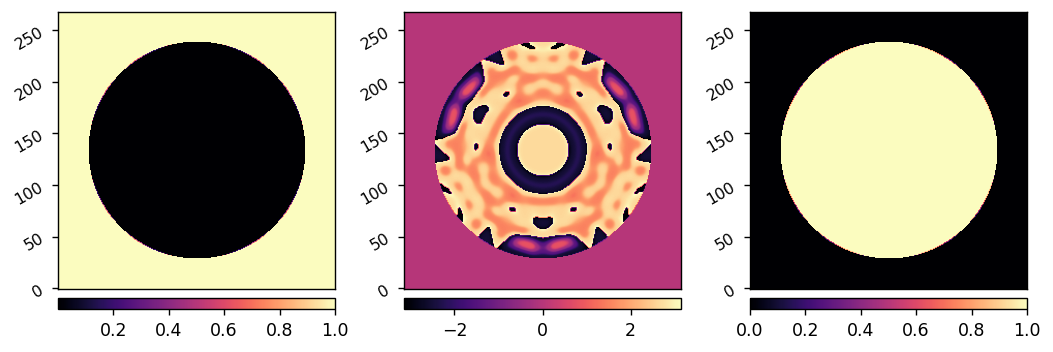

In [64]:
poppy_log.disabled = True

reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', npsf=128, psf_pixelscale_lamD=0.2, 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
#               use_opds=True,
             )

iwa = 2.8
owa = 9.7

misc.myimshow3(np.abs(hlc.fpm_phasor)**2, np.angle(hlc.fpm_phasor), hlc.fpm_mask)
if hlc.polaxis!=0: misc.myimshow2(hlc.POLMAP.amplitude, hlc.POLMAP.opd)

Propagating wavelength 575.000 nm.
PSF calculated in 0.288s


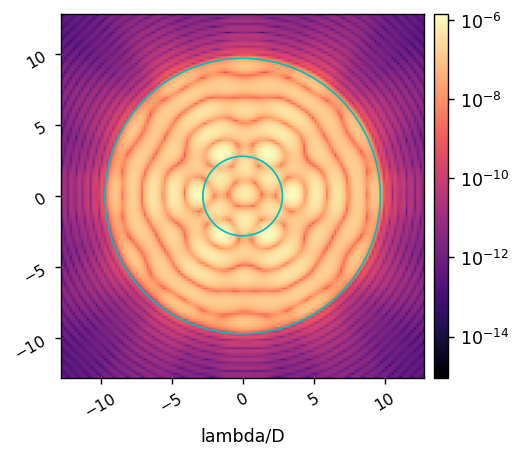

Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/pupil_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/polmap_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/primary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/secondary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/poma_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/m3_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/m4_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/m5_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/tt_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/fsm_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/hlc/oap1_poppy.fits
Wavefront saved to: 

In [65]:
wfs = hlc.calc_wfs()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, )

wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/hlc')
for i,wf in enumerate(wfs):
    save_wf(wf, hlc.optics[i])

(268, 268)


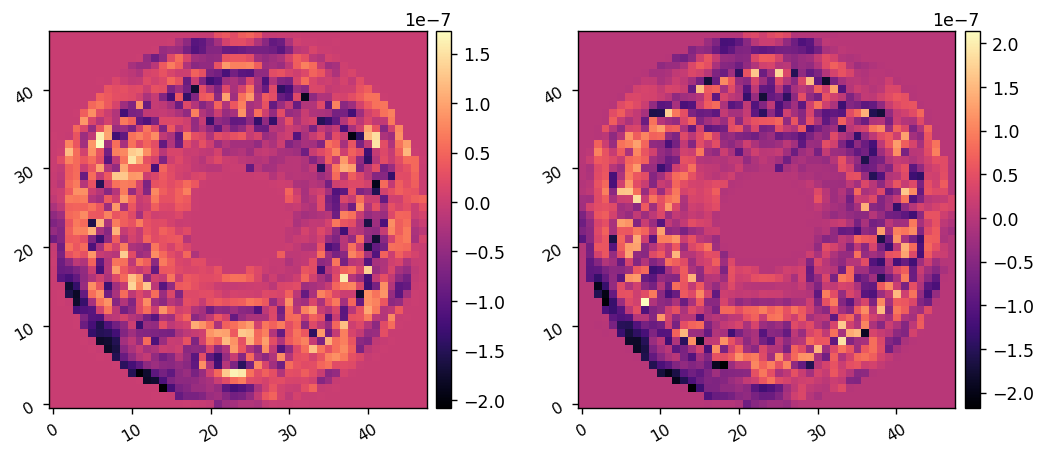

In [62]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', npsf=128, psf_pixelscale_lamD=0.2, 
              use_fpm=True, 
              use_pupil_defocus=True, use_opds=True,)

iwa = 2.8
owa = 9.7

dm1_fpath = dm_dir + 'hlc_best_contrast_dm1.fits'
dm2_fpath = dm_dir + 'hlc_best_contrast_dm2.fits'

dm1_cmd = 2*fits.getdata(dm1_fpath)
dm2_cmd = 2*fits.getdata(dm2_fpath)

misc.myimshow2(dm1_cmd, dm2_cmd)

hlc.set_dm1(dm1_cmd)
hlc.set_dm2(dm2_cmd)

wfs = hlc.calc_wfs()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=hlc.psf_pixelscale_lamD, patches=patches, )

# wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/hlc')
# for i,wf in enumerate(wfs):
#     save_wf(wf, hlc.optics[i])

# SPC-Wide

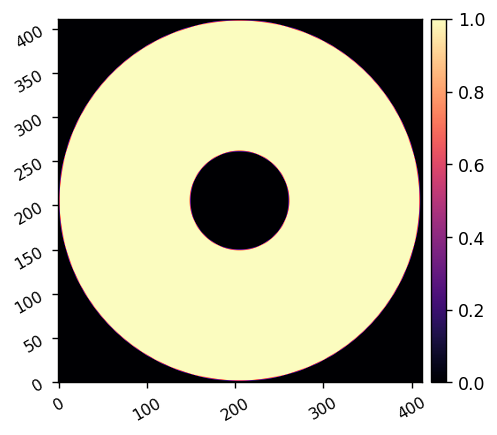

In [58]:
poppy_log.disabled = True

reload(cgi)
spcw = cgi.CGI(cgi_mode='spc-wide', npsf=256, psf_pixelscale_lamD=0.2, 
               polaxis=0,
               use_fpm=True,
               use_pupil_defocus=False)
iwa = 5.9
owa = 20.1

misc.myimshow(spcw.FPM.amplitude)
if spcw.polaxis!=0: misc.myimshow2(spcw.POLMAP.amplitude, spcw.POLMAP.opd)

Propagating wavelength 825.000 nm.
PSF calculated in 0.314s


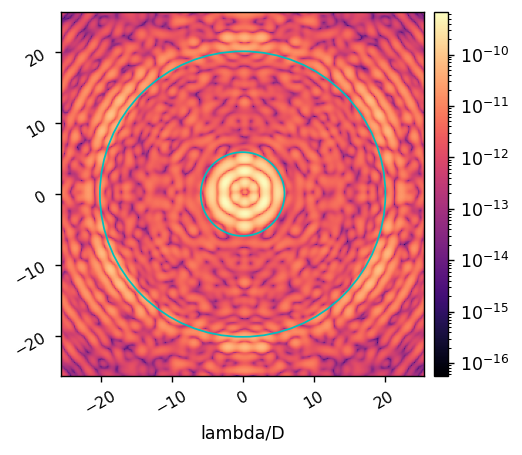

Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/pupil_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/polmap_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/primary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/secondary_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/poma_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m3_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m4_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/m5_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/tt_fold_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide/fsm_poppy.fits
Wavefront saved to: /groups/douglase/kians-data-files/roma

In [59]:
wfs = spcw.calc_wfs()

psf_mono = wfs[-1].intensity

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow(psf_mono, lognorm=True, pxscl=spcw.psf_pixelscale_lamD, patches=patches)

wf_dir = Path('/groups/douglase/kians-data-files/roman-cgi-wfs/spc-wide')
for i,wf in enumerate(wfs):
    save_wf(wf, spcw.optics[i])